# test communication with boxcar

In [1]:
import pyvisa
rm = pyvisa.ResourceManager()
print(rm.list_resources())

KeyboardInterrupt: 

In [ ]:
import pyvisa

rm = pyvisa.ResourceManager()
inst = rm.open_resource("GPIB0::16::INSTR")
inst.timeout = 5000  # Set timeout to 5 seconds

inst.write("?2")  # Send status query
response = inst.read()

print("SR245 Response:", response)



VisaIOError: VI_ERROR_CONN_LOST (-1073807194): The connection for the given session has been lost.

# test communication with crylas laser

In [ ]:
import serial
import time

try:
    ser = serial.Serial(port='COM7', baudrate=19200, timeout=1)
    ser.write(b'st\r')

    time.sleep(1)
    ser.write(b'vs\r')
    response = ser.read(100)
    print(f"Status: {response.decode(errors='ignore')}")
    ser.write(b'rs\r')

except serial.SerialException as e:
    print(f"Serial error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    if 'ser' in locals() and ser.is_open:
        ser.close()
        print("Serial port closed.")


Status: st
>vs 0D 1D
>
Serial port closed.


In [ ]:
# get status

from laser_control import LaserController

# 初期化
try:
    laser = LaserController(port="COM7")  # ポート番号は必要に応じて変更
    
    # ID・周波数・状態
    print("=== Basic Laser Info ===")
    print("ID:", laser.get_id())
    print("Frequency (kHz):", laser.get_frequency())
    print("Status:", laser.get_status())

    # PD電圧
    print("PD voltage(mV):", laser.get_pd_voltage())

    # === エラー情報 ===
    print("\n=== Error Information ===")
    raw_error = laser.get_error_raw()
    print("Raw Error Response:", raw_error)

    
    decoded = laser.get_error_decoded()

    if "error" in decoded:
        print("Decoded Error Status: ERROR -", decoded["error"])
    else:
        active_flags = {k: v for k, v in decoded.items() if v}
        if not active_flags:
            print("Decoded Error Status: ALL CLEAR")
        else:
            print("Decoded Error Status:")
            for key in active_flags:
                print(f"  {key}: ACTIVE")


    # === 全パラメータ（生＋デコード）===
    print("\n=== All Parameters (from di 7FFF → ga) ===")
    print("Raw Parameter Output:")
    raw_params = laser.request_all_params()
    print(raw_params)

    print("\nParsed Parameters (decoded):")
    decoded_params = laser.get_all_parameters(decoded=True)
    if isinstance(decoded_params, dict):
        for key, value in decoded_params.items():
            print(f"  {key}: {value}")
    else:
        print("  Failed to decode parameters.")

    laser.close()

except Exception as e:
    print(e)


=== Basic Laser Info ===
ID: DX2810-208-2 Q3,Haupt208,Temp122,Las119,Mod137,#5324
>
Frequency (kHz): 1000
Status: {'raw': 'vs 0D 3C\r\n>', 'hex_bytes': ['0D', '3C'], 'operation_byte': 13, 'status_byte': 60, 'flags': {'TEC1_On': True, 'TEC1_OK': False, 'TEC2_On': False, 'TEC2_OK': False, 'Laser_On': True, 'Laser_OK': True, 'Modulation_On': True, 'Master_Mode': False, 'Laser_ready': True, 'Debug_Mode': False, 'Set_parameters': True, 'Mem_Access': False, 'Interlock_open': False, 'Fatal_error': False}}
PD voltage(mV): 3213

=== Error Information ===
Raw Error Response: er 0 00000000
>
Decoded Error Status: ALL CLEAR

=== All Parameters (from di 7FFF → ga) ===
Raw Parameter Output:
{28370 35700 36659 32000 -1799 000 000 03226 00000 00760 02012 00000 0D 3C 12156 0 0 0}
>

Parsed Parameters (decoded):
  case_temp_C: 28.493
  set_TEC1_temp_C: 35.7
  real_TEC1_temp_C: 35.95
  set_TEC2_temp_C: 32.0
  real_TEC2_temp_C: -1.707
  TEC1_percent: 0
  TEC2_percent: 0
  PD_voltage_mV: 3195
  PD_target_m

In [ ]:
# get status

from laser_control import LaserController

# 初期化
try:
    laser = LaserController(port="COM7")  # ポート番号は必要に応じて変更
    
    status = laser.get_status()
    print("Raw vs bytes:", status["raw"])
    print("Operation byte:", status["operation_byte"])
    print("Status  byte:", status["status_byte"])
    print("Decoded flags:")
    for name, val in status["flags"].items():
        print(f"  {name:15}: {val}")

    laser.close()

except Exception as e:
    print(e)


Raw vs bytes: vs 09 19
>
Operation byte: 9
Status  byte: 25
Decoded flags:
  TEC1_On        : True
  TEC1_OK        : True
  TEC2_On        : False
  TEC2_OK        : False
  Laser_On       : False
  Laser_OK       : False
  Modulation_On  : True
  Master_Mode    : False
  Laser_ready    : True
  Debug_Mode     : False
  Set_parameters : False
  Mem_Access     : False
  Interlock_open : False
  Fatal_error    : False


In [4]:
laser.close()

2025-07-18 12:10:32,575 - INFO - Laser connection closed


In [1]:
from laser_control import CrylasQLaserController, CrylasQLaserDecoder
import time
PORT = "COM7"  # 実際のポートに合わせて変更
laser = None
decoder = CrylasQLaserDecoder()

try:
    laser = CrylasQLaserController(port=PORT)
    print("LaserController initialized.")

    # 2. basic information
    print("Firmware:", laser.firmware)
    print("All info:", laser.laser_info)
    print("Laser Type:", laser.laser_type)
    print("Serial Number:", laser.serial_number)
    print("Shipping Date:", laser.shipping_date)
    print("Additional Info:", laser.additional_info)

    # 3. status bytes
    status = laser.status
    print("Status:", status)

    # 4. laser operation
    laser.start()
    time.sleep(1)
    laser.stop()
    time.sleep(1)

    # 5. rep rate
    # property
    print("Repetition Rate (Hz):", laser.rep_rate)
    print("Max Allowed Rep Rate:", laser.max_allowed_rep_rate)

    # setter
    laser.rep_rate = 500
    time.sleep(0.5)
    print("Repetition Rate (Hz):", laser.rep_rate)
    
    laser.rep_rate = 1000
    # time.sleep(0.5)
    print("Repetition Rate (Hz):", laser.rep_rate)

    # 6. trigger
    print("Trigger Mode:", laser.trigger_mode)

    # 7. error status
    print("Last Error Message:", laser.last_error_message)
    laser.clear_error()

    # 8. PD status
    print("PD Voltage [mV]:", laser.photodiode_voltage)
    
    # laser.start_photodiode_voltage_stream
    # time.sleep(2)
    # print(laser.receive_response)
    # laser.stop_stream()

    # 9. operation condition
    print("Operating Hours:", laser.operating_hours)
    print("Number of Emitted Pulses:", laser.number_emitted_pulses)

    # 10. decoding
    print(decoder.status_byte_decoded(laser.status))
    print(decoder.get_error_decoded(laser.last_error_message))

except serial.SerialException as e:
    print(f"Serial error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    if laser is not None:
        laser.close()

2025-07-18 16:07:24,878 - INFO - laser on


LaserController initialized.
Firmware: DX2810-208-2Q3,Haupt208,Temp122,Las119,Mod137,#5324
All info: >im 106403__ 00002233 160424 ________________
Laser Type: 106403__
Serial Number: 00002233
Shipping Date: 160424
Additional Info: ________________
Status: ['>vs', '09', '19']


2025-07-18 16:07:25,880 - INFO - laser off


Repetition Rate (Hz): 1000
Max Allowed Rep Rate: 2500


2025-07-18 16:07:27,531 - INFO - Laser connection closed


Repetition Rate (Hz): 500
Repetition Rate (Hz): nan
Trigger Mode: 0
Last Error Message: ['>er', '0', '00000000']
PD Voltage [mV]: 0.0
Operating Hours: 187.0
Number of Emitted Pulses: 769874248
{'operation_byte': 9, 'status_byte': 25, 'flags': {'TEC1_On': True, 'TEC1_OK': True, 'TEC2_On': False, 'TEC2_OK': False, 'Laser_On': False, 'Laser_OK': False, 'Modulation_On': True, 'Master_Mode': False, 'Laser_ready': True, 'Debug_Mode': False, 'Set_parameters': False, 'Mem_Access': False, 'Interlock_open': False, 'Fatal_error': False}}
{'Supply voltage too low': False, 'Supply voltage too high': False, 'TEC1 temperature out of range': False, 'TEC2 temperature out of range': False, 'TEC1 temperature not adjustable': False, 'TEC2 temperature not adjustable': False, 'Receive Time-Out': False, 'Unknown command': False, 'Command forbidden in this mode': False, 'Parameter out of range': False, 'Too many symbols in command': False, 'No connection to laser head': False, 'LD power supply too low': False

In [ ]:
laser.stop_stream

In [3]:
from laser_control import CrylasQLaserController
import time
PORT = "COM7"  # 実際のポートに合わせて変更

try:
    laser.send_command("di 8008")
    print(laser.receive_response)
    time.sleep(3)
    laser.send_command("di 0000")

except serial.SerialException as e:
    print(f"Serial error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    if laser is not None:
        laser.close()

2025-07-18 13:48:24,837 - INFO - Laser connection closed


<bound method CrylasQLaserController.receive_response of <laser_control.CrylasQLaserController object at 0x00000249F53D2C10>>


2025-07-18 13:48:27,882 - INFO - Laser connection closed


# test communication with stage

In [ ]:
# import stage_control
import time
from stage_control import rotation_stage, translation_stage
from stage_control import *

print("Running homing (reset) for rotation stage...")
reset_rotation_stage()
time.sleep(2.0)
print(f"Rotation stage position after reset: {rotation_stage.degree:.4f} deg")

print("Running homing (reset) for translation stage...")
reset_translation_stage()
time.sleep(2.0)
print(f"Translation stage position after reset: {translation_stage.millimeter:.4f} mm")


Running homing (reset) for rotation stage...
[WARNING] Initial command failed: WriteFile failed (PermissionError(13, 'The device does not recognize the command.', None, 22))
[ERROR] Reconnection failed: could not open port 'COM4': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)


PortNotOpenError: Attempting to use a port that is not open

In [15]:
stage.move_to_angle(0)

[WARNING] Stage command failed: Attempting to use a port that is not open
[INFO] Reconnection successful. Retrying...


In [ ]:
# 原点復帰方式の確認。現状回転ステージは原点復帰機能がオフになっている

response = rotation_stage.raw_command("?:ORG2")
print("Stage response:", response)


Stage response: 0


In [ ]:
# ケーブル抜き差ししてエラーが出たら明示的に閉じて再度オープン
rotation_stage.close()
translation_stage.close()

rotation_stage.open()
translation_stage.open()


In [ ]:
print("Testing rotation stage...")
move_to_angle(0)
print(f"Current angle: {get_current_angle():.2f} deg")

print("Testing translation stage...")
move_to_position_mm(17.5)
print(f"Current position: {get_current_position_mm():.3f} mm")

Testing rotation stage...
Current angle: 0.00 deg
Testing translation stage...
Current position: 17.500 mm


In [ ]:
# クラス化したので呼び出し方を変更。
from stage_control import StageController

stage = StageController(port="COM4")

stage.move_to_angle(-10)
print("Angle:", stage.get_angle())
stage.move_to_mm(17.5)
# stage.reset_translation()
print("Position:", stage.get_position_mm())

# stage.reset_translation()
stage.close_all()


[WARNING] Stage command failed: Attempting to use a port that is not open
[INFO] Reconnection successful. Retrying...
Angle: 350.0
Position: 17.5


In [13]:
stage.close_all()

In [ ]:
from stage_control import StageController
import time
stage = StageController(port="COM4")

angle = stage.get_angle()


for i in range(10):
    stage.move_to_angle(angle)
    time.sleep(0.1)
    angle += 3

stage.close_all()

[WARNING] Stage command failed: Attempting to use a port that is not open
[INFO] Reconnection successful. Retrying...


In [ ]:
from osms2035_control import OSMS2035Controller
from osms60yaw_control import OSMS60YAWController
import time
import serial

port = "COM4"
stage1 = None
stage2 = None

try:
    stage1 = OSMS2035Controller(port=port, axis=1)
    stage2 = OSMS60YAWController(port=port, axis=2)

    # stage 1
    print("Reset stage1")
    stage1.reset()

    print("Move stage1 to 5.0 mm")
    stage1.millimeter = 5.0
    print("Current mm:", stage1.millimeter)

    print("Move stage1 to 10.0 mm")
    stage1.millimeter = 5.0
    print("Current mm:", stage1.millimeter)

    print("Pulse -> mm:", stage1.pos2mm(1000))
    print("mm -> Pulse:", stage1.mm2pos(5.0))

    print("Stop stage1")
    stage1.stop()

    # stage 2
    print("Reset stage2")
    stage2.reset()

    print("Move stage2 to 45 deg")
    stage2.degree = 45.0
    print("Current deg:", stage2.degree)

    print("Pulse -> deg:", stage2.pos2deg(1000))
    print("Deg -> Pulse:", stage2.deg2pos(1.0))

    print("avoid limit stop at -2.5 deg")
    stage2.move_to_angle(1.0, direction="cw")

    print("Stop stage2")
    stage2.stop()

    print("Position1:", stage1.pos2mm(stage1.position1))
    print("Position2:", stage2.pos2deg(stage2.position2))

    print("Status1:", stage1.get_status1())
    print("Status2:", stage2.get_status2())
    print("Version:", stage1.get_version())

    # print("Logical zero (stage1)")
    # stage1.set_logical_zero(axis=1)

except serial.SerialException as e:
    print(f"Serial error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    if stage1 is not None:
        stage1.close()
    if stage2 is not None:
        stage2.close()


2025-07-21 22:11:37,066 - INFO - OSMS2085Controller initialized on port COM4 (axis 1)
2025-07-21 22:11:37,068 - INFO - OSMS60YAWController initialized on port COM4 (axis 2)
2025-07-21 22:11:37,113 - INFO - Returned to origin successfully


Reset stage1
Move stage1 to 5.0 mm
Current mm: 5.0
Move stage1 to 10.0 mm
Current mm: 5.0
Pulse -> mm: 1.0
mm -> Pulse: 5000
Stop stage1


2025-07-21 22:11:42,857 - INFO - Returned to origin successfully


Reset stage2
Move stage2 to 45 deg


2025-07-21 22:11:43,142 - ERROR - Cannot rotate cw across -2.5 deg


Current deg: 45.0
Pulse -> deg: 1.0
Deg -> Pulse: 1000
avoid limit stop at -2.5 deg


2025-07-21 22:11:52,236 - INFO - Moved to 1.00° (direction: ccw)


Stop stage2
Position1: 5.0
Position2: 1.0
Status1: (5000, 1000, 'K', 'K', 'R')
Status2: R
Version: V1.00


2025-07-21 22:11:52,471 - INFO - Stage connection safely closed
2025-07-21 22:11:52,474 - INFO - Stage connection safely closed


2025-08-04 18:54:27,629 - INFO - in gsc02_control.py - Stage connection safely closed
2025-08-04 18:54:27,631 - INFO - in gsc02_control.py - Stage connection safely closed
2025-08-04 18:54:27,632 - INFO - in osms60yaw_control.py - osms60yaw is safely closed
2025-08-04 18:54:27,715 - INFO - in osms2035_control.py - OSMS2035Controller initialized on port COM4 (axis 1)
2025-08-04 18:54:27,716 - INFO - in osms60yaw_control.py - OSMS60YAWController initialized on port COM4 (axis 2)
2025-08-04 18:54:47,130 - INFO - in osms60yaw_control.py - relative pulse: -4000
2025-08-04 18:54:47,220 - INFO - in osms60yaw_control.py - set relative pulse: True, axis: 2
2025-08-04 18:54:47,262 - INFO - in osms60yaw_control.py - driving: True


Current deg: 0.0


2025-08-04 18:54:47,592 - INFO - in osms60yaw_control.py - Moved to -10.00° (direction: ccw)


Current deg: -2.5075


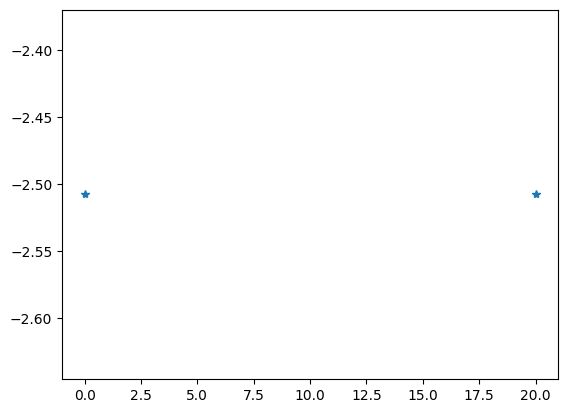

Current deg: -2.5075
stopping condition: M
stopping condition: M


2025-08-04 18:54:53,332 - INFO - in gsc02_control.py - Stage connection safely closed
2025-08-04 18:54:53,333 - INFO - in gsc02_control.py - Stage connection safely closed


In [2]:
from devices.osms2035_control import OSMS2035Controller
from devices.osms60yaw_control import OSMS60YAWController
import time
import serial
import numpy as np
from matplotlib import pyplot as plt

port = "COM4"
stage1 = None
stage2 = None

try:
    stage1 = OSMS2035Controller(port=port, axis=1)
    stage2 = OSMS60YAWController(port=port, axis=2)

    # print(stage2.raw_command("?:ORG2"))
    # stage2.return_origin("-", stage2.axis)
    # print("Current deg:", stage2.degree)

    stage2.return_origin("-", stage2.axis)
    print("Current deg:", stage2.degree)
    stage2.move_to_angle(-10, "auto")
    print("Current deg:", stage2.degree)

    x = [0]
    y = [stage2.degree]
    for i in range(18):
        stage2.set_relative_pulse(-8000, stage2.axis) #20 deg
        stage2.driving()
        x.append((i+1)*20)
        y.append(stage2.degree)
        
        if stage2.ack2 == "M":
            break

    plt.plot(x, y, "*")
    plt.show()
    # stage2.jog("-", 2)
    # stage2.driving()

    time.sleep(5)
    print("Current deg:", stage2.degree)
    print("stopping condition:", stage2.ack2)
    stage2.stop() 
    print("stopping condition:", stage2.ack2)

    

except serial.SerialException as e:
    print(f"Serial error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    if stage1 is not None:
        stage1.close()
    if stage2 is not None:
        stage2.close()

In [1]:
from devices.osms2035_control import OSMS2035Controller
from devices.osms60yaw_control import OSMS60YAWController
import time
import serial
import numpy as np
from matplotlib import pyplot as plt

port = "COM4"
stage1 = None
stage2 = None

try:
    stage1 = OSMS2035Controller(port=port, axis=1)
    stage2 = OSMS60YAWController(port=port, axis=2)

    print("jog to +")
    print("Current deg:", stage2.degree)
    stage2.jog("+", 2)
    stage2.driving()
    time.sleep(3)
    stage2.stop()
    print("Current deg:", stage2.degree)

    print("jog to -")
    print("Current deg:", stage2.degree)
    stage2.jog("-", 2)
    stage2.driving()
    time.sleep(3)
    stage2.stop()
    print("Current deg:", stage2.degree)

    

except serial.SerialException as e:
    print(f"Serial error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    if stage1 is not None:
        stage1.close()
    if stage2 is not None:
        stage2.close()

2025-08-04 18:50:48,181 - INFO - in osms2035_control.py - OSMS2035Controller initialized on port COM4 (axis 1)
2025-08-04 18:50:48,183 - INFO - in osms60yaw_control.py - OSMS60YAWController initialized on port COM4 (axis 2)


jog to +
Current deg: 172.4925
Current deg: 176.4
jog to -
Current deg: 176.4


2025-08-04 18:50:54,738 - INFO - in gsc02_control.py - Stage connection safely closed
2025-08-04 18:50:54,740 - INFO - in gsc02_control.py - Stage connection safely closed


Current deg: 172.595


つまり、＋がccw、ーがcw。そして座標値もccw方向が正
なので、角度は単位円と同じ方向(ccw)が正
そしてDIPスイッチの5番をoffにしたことで回転軸の原点復帰が可能になり、ステージ上の目盛りと出力される角度が一致

In [1]:

from devices.osms2035_control import OSMS2035Controller
from devices.osms60yaw_control import OSMS60YAWController
import time
import serial

port = "COM4"
stage1 = None
stage2 = None

try:
    stage1 = OSMS2035Controller(port=port, axis=1)
    stage2 = OSMS60YAWController(port=port, axis=2)

    # stage 1
    print("Reset stage1")
    stage1.reset()

    print("Move stage1 to 5.0 mm")
    stage1.millimeter = 5.0
    print("Current mm:", stage1.millimeter)

    print("Pulse -> mm:", stage1.pos2mm(1000))
    print("mm -> Pulse:", stage1.mm2pos(5.0))

    print("Stop stage1")
    stage1.stop()

    # stage 2
    print("Reset stage2")
    stage2.reset()

    print("Move stage2 to 45 deg")
    stage2.degree = 45.0
    print("Current deg:", stage2.degree)

    print("Pulse -> deg:", stage2.pos2deg(1000))
    print("Deg -> Pulse:", stage2.deg2pos(1.0))

    print("avoid limit stop at -2.5 deg")
    stage2.move_to_angle(1.0, direction="cw")

    print("Stop stage2")
    stage2.stop()

    print("Position1:", stage1.pos2mm(stage1.position1))
    print("Position2:", stage2.pos2deg(stage2.position2))

    print("Status1:", stage1.get_status1())
    print("Status2:", stage2.get_status2())
    print("Version:", stage1.get_version())

    # print("Logical zero (stage1)")
    # stage1.set_logical_zero(axis=1)

except serial.SerialException as e:
    print(f"Serial error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    if stage1 is not None:
        stage1.close()
    if stage2 is not None:
        stage2.close()


2025-08-04 17:47:47,419 - INFO - in osms2035_control.py - OSMS2035Controller initialized on port COM4 (axis 1)
2025-08-04 17:47:47,421 - INFO - in osms60yaw_control.py - OSMS60YAWController initialized on port COM4 (axis 2)


Reset stage1
Move stage1 to 5.0 mm


2025-08-04 17:47:54,679 - INFO - in osms60yaw_control.py - relative pulse: 0
2025-08-04 17:47:54,766 - INFO - in osms60yaw_control.py - set relative pulse: True, axis: 2


Current mm: 5.0
Pulse -> mm: 1.0
mm -> Pulse: 5000
Stop stage1
Reset stage2


2025-08-04 17:47:54,851 - INFO - in osms60yaw_control.py - driving: True
2025-08-04 17:47:54,889 - INFO - in osms60yaw_control.py - Moved to 0.00° (direction: cw)


Move stage2 to 45 deg


2025-08-04 17:47:59,032 - ERROR - in osms60yaw_control.py - Cannot rotate cw across -2.5 deg
NoneType: None
2025-08-04 17:47:59,033 - INFO - in osms60yaw_control.py - relative pulse: -17600
2025-08-04 17:47:59,123 - INFO - in osms60yaw_control.py - set relative pulse: True, axis: 2


Current deg: 45.0
Pulse -> deg: 2.5
Deg -> Pulse: 400
avoid limit stop at -2.5 deg


2025-08-04 17:48:02,894 - INFO - in osms60yaw_control.py - driving: True
2025-08-04 17:48:02,933 - INFO - in osms60yaw_control.py - Moved to 1.00° (direction: ccw)


Stop stage2
Position1: 5.0
Position2: 1.0
Status1: (5000, 400, 'K', 'K', 'R')


2025-08-04 17:48:03,203 - INFO - in gsc02_control.py - Stage connection safely closed
2025-08-04 17:48:03,206 - INFO - in gsc02_control.py - Stage connection safely closed


Status2: R
Version: V1.00


In [8]:
# test for limit sensor and input value range


from devices.osms2035_control import OSMS2035Controller
from devices.osms60yaw_control import OSMS60YAWController
import time
import serial

port = "COM3"
stage1 = None
stage2 = None

try:
    time.sleep(5.0)
    stage1 = OSMS2035Controller(port=port, axis=1)
    stage2 = OSMS60YAWController(port=port, axis=2)

    # reset
    # stage2.reset()
    stage2.degree = 0
    print(f"degree: {stage2.degree}")

    # limit sensor at -2.5 deg
    stage2.degree = 20
    print(f"degree: {stage2.degree}")
    # it's gonna stop at -2.5 deg...?
    stage2.degree = -20
    print(f"degree: {stage2.degree}")
    

    # 座標が0付近でなくても(360,720とか)リミットセンサは効く？
    stage2.degree = 380
    print(f"degree: {stage2.degree}")
    # it's gonna stop at 357.5 deg...?
    stage2.degree = 340
    print(f"degree: {stage2.degree}")

    
except serial.SerialException as e:
    print(f"Serial error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    if stage1 is not None:
        stage1.close()
    if stage2 is not None:
        stage2.close()


2025-10-13 17:30:49,600 - INFO - in gsc02_control.py - Stage connection safely closed
2025-10-13 17:30:49,600 - INFO - in gsc02_control.py - Stage connection safely closed
2025-10-13 17:30:49,602 - INFO - in osms60yaw_control.py - osms60yaw is safely closed
2025-10-13 17:30:54,741 - INFO - in osms2035_control.py - OSMS2035Controller initialized on port COM3 (axis 1)
2025-10-13 17:30:54,741 - INFO - in osms60yaw_control.py - OSMS60YAWController initialized on port COM3 (axis 2)


degree: 0.0
degree: 20.0
degree: -2.5425
degree: 380.0


2025-10-13 17:31:32,496 - INFO - in gsc02_control.py - Stage connection safely closed
2025-10-13 17:31:32,496 - INFO - in gsc02_control.py - Stage connection safely closed


degree: 357.4575


# test result

### reset
degree: 360.0 -> worked

### 20 deg
degree: 337.6575 -> stoped at -2.5 deg, didn't work and return deg is wrong...
### -20 deg
degree: 337.6575

### 380 deg
degree: 380.0 -> moved to 40(400) deg, returned degree is wrong...
## 340 deg
degree: 340.0 -> moved to 0(360) deg, returned degree is wrong...

### 0 deg
degree: 337.6575 -> stoped at -2.5 deg, didn't work and return deg is wrong...

In [9]:
# test for limit sensor and input value range


from devices.osms2035_control import OSMS2035Controller
from devices.osms60yaw_control import OSMS60YAWController
import time
import serial

port = "COM3"
stage1 = None
stage2 = None

try:
    time.sleep(5.0)
    stage1 = OSMS2035Controller(port=port, axis=1)
    stage2 = OSMS60YAWController(port=port, axis=2)

    print(f"degree: {stage2.degree}")

    stage2.return_origin("-", stage2.axis)

    print(f"degree: {stage2.degree}")
    stage2.degree = 20
    print(f"degree: {stage2.degree}")


    
except serial.SerialException as e:
    print(f"Serial error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    if stage1 is not None:
        stage1.close()
    if stage2 is not None:
        stage2.close()


2025-10-14 14:10:21,274 - INFO - in gsc02_control.py - Stage connection safely closed
2025-10-14 14:10:21,274 - INFO - in gsc02_control.py - Stage connection safely closed
2025-10-14 14:10:21,278 - INFO - in osms60yaw_control.py - osms60yaw is safely closed
2025-10-14 14:10:26,412 - INFO - in osms2035_control.py - OSMS2035Controller initialized on port COM3 (axis 1)
2025-10-14 14:10:26,412 - INFO - in osms60yaw_control.py - OSMS60YAWController initialized on port COM3 (axis 2)


degree: 0.0
degree: 0.0


2025-10-14 14:10:33,721 - INFO - in gsc02_control.py - Stage connection safely closed
2025-10-14 14:10:33,721 - INFO - in gsc02_control.py - Stage connection safely closed


degree: 20.0
